In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
# lonMin = (float)(config['REGION']['LON_MIN'])
# lonMax = (float)(config['REGION']['LON_MAX'])

# latMin = (float)(config['REGION']['LAT_MIN'])
# latMax = (float)(config['REGION']['LAT_MAX'])

lonMin = (float)(-120.00)
lonMax = (float)(-119.50)

latMin = (float)(34.12)
latMax = (float)(34.24)

print(lonMin,latMin)
print(lonMax,latMax)

# increStep = (float)(config['HEATMAP']['INCR_STEP'])
# incrRes = (int)(config['HEATMAP']['INCR_RES'])
increStep = (float)(0.01)
incrRes = (int)(2)

-120.0 34.12
-119.5 34.24


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [7]:
fileDir = "../Data/M120_00_M190_50_34_12_34_24/HalfHourlyLE/"
dirToStore = "../Data/M120_00_M190_50_34_12_34_24/HalfHourlyTPSec/"
# fileDir = "../Data/M121_00_M119_00_33_50_34_50/HalfHourlyLE/"
# dirToStore = "../Data/M121_00_M119_00_33_50_34_50/HalfHourlyTPSec/"

In [8]:
#1 to load existing data
loadExisting = 1
neighTPCount = []
for i in range(totalStates):
    fileToRead = dirToStore + str(i) + '.npy'
    if(loadExisting == 1):
        neighTPCount.append(np.load(fileToRead))
    else:
        neighTPCount.append(np.zeros((totalStates * totalStates)))

In [9]:
def get_index_from_lon_lat(lon,lat):
    retVal = -1
    for boundary in boundaryArray: 
        if(lon >= boundary[0]) and (lon < boundary[1]) \
            and (lat >= boundary[2]) and (lat < boundary[3]):
            retVal = boundary[4]
            break 
    return retVal

In [10]:
def clear_tm_matrix():
    for i in range(horizontalAxis.shape[0] * verticalAxis.shape[0]):
        neighTPCount[i].fill(0)
        
def compute_transition_prob(firstNum):
    fileName1 = fileDir + str(firstNum) + '.csv'
    fileName2 = fileDir + str(firstNum+1) + '.csv'
    fileName3 = fileDir + str(firstNum+2) + '.csv'

    #transition probability for previous hour
    firstDF,_ = aISDM.load_data_from_csv(fileName1)
    #transition probability for current hour
    secondDF,_ = aISDM.load_data_from_csv(fileName2)
    #transition probability for next hour
    thirdDF,_ = aISDM.load_data_from_csv(fileName3)
    
    #vessels in previous hour
    prevVessels = aISDM.get_list_of_unique_mmsi(firstDF)
    #vessels in current hour
    currVessels = aISDM.get_list_of_unique_mmsi(secondDF)
    #vessels in next hour
    nextVessels = aISDM.get_list_of_unique_mmsi(thirdDF)
    
    #index based on MMSI
    #useful for indexing
    firstDF = firstDF.set_index('MMSI')
    secondDF = secondDF.set_index('MMSI')
    thirdDF = thirdDF.set_index('MMSI')
    
    #compute vessels of interest
    #this are vessels which are of interest
    vesselsOfInterest = list(set(prevVessels) & set(currVessels) & set(nextVessels))
    #iterate through every vessel
    #get the first LON and LAT coordinate for the first vessel
    for vessel in vesselsOfInterest:
        #get the LON and LAT value of the vessel
        #get the location where vessel was previously and is currently
        #now we have the location
        vesselPrevIndex = get_index_from_lon_lat(firstDF.loc[vessel,'LON'],firstDF.loc[vessel,'LAT'])
        vesselCurrIndex = get_index_from_lon_lat(secondDF.loc[vessel,'LON'],secondDF.loc[vessel,'LAT'])
        #now lets findout where this vessel is
        vesselNextIndex = get_index_from_lon_lat(thirdDF.loc[vessel,'LON'],thirdDF.loc[vessel,'LAT'])
        vesselPrevCurrIndex = (vesselPrevIndex * totalStates) + vesselCurrIndex
        neighTPCount[vesselNextIndex][vesselPrevCurrIndex] = neighTPCount[vesselNextIndex][vesselPrevCurrIndex] + 1

In [11]:
if(loadExisting == 0):
    clear_tm_matrix()
    for fileCounter in range(17519):
        try:
            compute_transition_prob(fileCounter)
            print("Done Computing %d"%(fileCounter))
        except KeyboardInterrupt:
            break

In [12]:
if(loadExisting == 0):
    #destination directory
    for neighb in range(totalStates):
        opFile = dirToStore + str(neighb)+'.npy'
        np.save(opFile, neighTPCount[neighb])

In [13]:
#first lets make sum of probabilities
#this sum should be equal to tPCurrentSum
sumCount = np.zeros(totalStates*totalStates)
for i in range(totalStates):
    sumCount = sumCount + neighTPCount[i]

In [14]:
if(loadExisting == 0):
    #make transition probability matrix
    #A_{ij} i.e. trantition from i to j
    tpMatrix = np.zeros(((totalStates*totalStates),totalStates))
    
    #we will first fill columns
    #then rows
    #just like numpy
    #so i will be row count
    #j will be column count
    # for i in range(1):
    for i in range(tpMatrix.shape[0]):
        for j in range(tpMatrix.shape[1]):
            if(sumCount[i] > 0):
                tpMatrix[i,j] = neighTPCount[j][i]/sumCount[i]
    #             print("YAY")
                if(tpMatrix[i,j] > 0):
                    print(tpMatrix[i,j])

In [15]:
opFile = dirToStore + 'TPM.npy'
if(loadExisting == 0):
    np.save(opFile,tpMatrix)
else:
    tpMatrix = np.load(opFile)

In [16]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

In [17]:
#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStatus):
    return (vesselStatus.T @ tpMatrix).flatten()

In [18]:
def generate_vessel_prev_cur_status(prevState,currState):
    vesselState = np.zeros((totalStates*totalStates))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

In [25]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  209251000  2017-01-06T07:28:57  34.13062 -119.50377  11.9 -124.6    286.0   
1  209251000  2017-01-06T07:59:37  34.15897 -119.61990  11.5 -124.6    285.0   
2  209251000  2017-01-06T08:29:37  34.18528 -119.73318  11.7 -125.6    285.0   
3  209251000  2017-01-06T08:59:48  34.20928 -119.84930  12.2 -126.6    287.0   
4  209251000  2017-01-06T09:28:56  34.23303 -119.96362  11.8 -125.6    288.0   
5  209251000  2017-01-06T09:37:07  34.23978 -119.99472  11.6 -123.6    289.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engine   
1  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engine   
2  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engine   
3  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engine   
4  CSCL PUSAN  IMO9307229    C4NK2      1004.0  under way using engin

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  211335760  2017-02-26T19:59:41  34.13350 -119.52315  10.6 -124.0    284.0   
1  211335760  2017-02-26T20:29:01  34.15590 -119.62248  10.4 -124.5    284.0   
2  211335760  2017-02-26T20:59:02  34.17911 -119.72595  10.7 -124.6    284.0   
3  211335760  2017-02-26T21:29:12  34.20260 -119.83026  10.5 -124.1    285.0   
4  211335760  2017-02-26T21:59:02  34.22543 -119.93194  10.4 -124.9    282.0   
5  211335760  2017-02-26T22:17:22  34.23930 -119.99408  10.5 -124.1    285.0   

          VesselName         IMO CallSign  VesselType                  Status  \
0  ROTTERDAM EXPRESS  IMO9193317     DMRX      1004.0  under way using engine   
1  ROTTERDAM EXPRESS  IMO9193317     DMRX      1004.0  under way using engine   
2  ROTTERDAM EXPRESS  IMO9193317     DMRX      1004.0  under way using engine   
3  ROTTERDAM EXPRESS  IMO9193317     DMRX      1004.0  under way using engine   
4  ROTT

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  211693000  2017-01-21T20:29:17  34.12922 -119.50743  11.8 -123.2    285.0   
1  211693000  2017-01-21T20:59:48  34.15501 -119.62290  11.6 -125.7    283.0   
2  211693000  2017-01-21T21:29:48  34.18173 -119.73589  11.6 -122.7    285.0   
3  211693000  2017-01-21T21:59:58  34.20843 -119.84765  11.2 -123.6    284.0   
4  211693000  2017-01-21T22:28:56  34.23263 -119.95500  11.5 -126.7    280.0   
5  211693000  2017-01-21T22:37:48  34.23964 -119.98896  11.3 -125.6    281.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  NORTHERN JULIE  IMO9294989     DNDD      1004.0  under way using engine   
1  NORTHERN JULIE  IMO9294989     DNDD      1004.0  under way using engine   
2  NORTHERN JULIE  IMO9294989     DNDD      1004.0  under way using engine   
3  NORTHERN JULIE  IMO9294989     DNDD      1004.0  under way using engine   
4  NORTHERN JULIE  IMO9294989     DND

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  219155000  2017-10-23T04:29:29  34.15124 -119.58457  9.8 -122.6    285.0   
1  219155000  2017-10-23T04:59:29  34.17061 -119.68065  9.7 -127.3    282.0   
2  219155000  2017-10-23T05:29:28  34.18836 -119.77520  9.3 -125.6    284.0   
3  219155000  2017-10-23T05:59:10  34.20841 -119.86249  9.0 -122.3    284.0   
4  219155000  2017-10-23T06:28:59  34.23224 -119.94970  9.3 -121.4    284.0   
5  219155000  2017-10-23T06:39:30  34.23992 -119.98178  9.6 -123.7    282.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  MAERSK EVORA  IMO9458080    OXVS2      1004.0  under way using engine   
1  MAERSK EVORA  IMO9458080    OXVS2      1004.0  under way using engine   
2  MAERSK EVORA  IMO9458080    OXVS2      1004.0  under way using engine   
3  MAERSK EVORA  IMO9458080    OXVS2      1004.0  under way using engine   
4  MAERSK EVORA  IMO9458080    OXVS2      1004.0  unde

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  220416000  2017-05-22T10:29:28  34.13128 -119.51240  9.6 -124.1    288.0   
1  220416000  2017-05-22T10:59:58  34.15257 -119.60506  9.0 -124.4    289.0   
2  220416000  2017-05-22T11:28:59  34.17179 -119.68827  8.7 -124.8    285.0   
3  220416000  2017-05-22T11:58:58  34.19080 -119.77078  8.4 -125.5    279.0   
4  220416000  2017-05-22T12:29:59  34.21041 -119.85570  8.6 -124.4    281.0   
5  220416000  2017-05-22T12:59:59  34.23045 -119.94269  9.2 -125.7    282.0   
6  220416000  2017-05-22T13:13:58  34.23996 -119.98506  9.5 -126.3    283.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  GEORG MAERSK  IMO9320257    OYGN2      1004.0  under way using engine   
1  GEORG MAERSK  IMO9320257    OYGN2      1004.0  under way using engine   
2  GEORG MAERSK  IMO9320257    OYGN2      1004.0  under way using engine   
3  GEORG MAERSK  IMO9320257    OYGN2      1004.0  u

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  220597000  2017-06-23T09:29:35  34.15819 -119.63931  22.1 -123.4    286.0   
1  220597000  2017-06-23T09:59:37  34.18294 -119.73443   3.7 -115.0    285.0   
2  220597000  2017-06-23T10:29:27  34.19147 -119.76291   2.8 -125.4    280.0   
3  220597000  2017-06-23T10:59:37  34.19940 -119.80856  11.4 -125.4    284.0   
4  220597000  2017-06-23T11:29:31  34.23070 -119.95701  14.8 -122.4    287.0   
5  220597000  2017-06-23T11:37:01  34.23991 -119.99556  16.3 -123.2    286.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  GUTHORM MAERSK  IMO9359040    OUJN2      1004.0  under way using engine   
1  GUTHORM MAERSK  IMO9359040    OUJN2      1004.0       not under command   
2  GUTHORM MAERSK  IMO9359040    OUJN2      1004.0       not under command   
3  GUTHORM MAERSK  IMO9359040    OUJN2      1004.0  under way using engine   
4  GUTHORM MAERSK  IMO9

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  229710000  2017-10-23T11:59:31  34.15290 -119.58623  10.1 -123.9    284.0   
1  229710000  2017-10-23T12:29:40  34.17376 -119.68445   9.9 -126.0    282.0   
2  229710000  2017-10-23T12:59:41  34.19352 -119.78032   9.7 -126.8    284.0   
3  229710000  2017-10-23T13:29:31  34.21438 -119.87456  10.2 -122.6    285.0   
4  229710000  2017-10-23T13:59:31  34.23769 -119.97251   9.8 -125.6    281.0   
5  229710000  2017-10-23T14:03:01  34.23993 -119.98345   9.7 -125.5    282.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0   THALATTA  IMO9702455  9HA3538      1004.0  under way using engine  199.97   
1   THALATTA  IMO9702455  9HA3538      1004.0  under way using engine  199.97   
2   THALATTA  IMO9702455  9HA3538      1004.0  under way using engine  199.97   
3   THALATTA  IMO9702455  9HA3538      1004.0  under way using engine  199.97   
4   THALATTA  IMO97024

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  229988000  2017-10-15T20:29:51  34.13798 -119.54312  10.4 -123.6    283.0   
1  229988000  2017-10-15T20:59:30  34.16035 -119.64152  10.1 -125.3    282.0   
2  229988000  2017-10-15T21:29:19  34.18207 -119.73785  10.0 -124.1    286.0   
3  229988000  2017-10-15T21:59:29  34.20437 -119.83577  10.1 -124.8    282.0   
4  229988000  2017-10-15T22:29:50  34.22623 -119.93240   9.7 -124.2    284.0   
5  229988000  2017-10-15T22:48:11  34.23947 -119.99098  10.0 -124.1    285.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  CMA CGM TAGE  IMO9674555  9HA3777      1004.0  under way using engine   
1  CMA CGM TAGE  IMO9674555  9HA3777      1004.0  under way using engine   
2  CMA CGM TAGE  IMO9674555  9HA3777      1004.0  under way using engine   
3  CMA CGM TAGE  IMO9674555  9HA3777      1004.0  under way using engine   
4  CMA CGM TAGE  IMO9674555  9HA

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  235010450  2017-05-20T08:29:40  34.12833 -119.50250  12.9 -122.6    285.0   
1  235010450  2017-05-20T08:58:51  34.15550 -119.62523  12.7 -126.6    285.0   
2  235010450  2017-05-20T09:28:59  34.18380 -119.74475  12.2 -123.6    285.0   
3  235010450  2017-05-20T09:59:00  34.21070 -119.86252  12.3 -126.6    282.0   
4  235010450  2017-05-20T10:28:50  34.23673 -119.98362  12.7 -124.6    284.0   
5  235010450  2017-05-20T10:31:10  34.23892 -119.99317  12.7 -124.6    284.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  EVER SMART  IMO9300403    MLBD9      1004.0  under way using engine   
1  EVER SMART  IMO9300403    MLBD9      1004.0  under way using engine   
2  EVER SMART  IMO9300403    MLBD9      1004.0  under way using engine   
3  EVER SMART  IMO9300403    MLBD9      1004.0  under way using engine   
4  EVER SMART  IMO9300403    MLBD9      10

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  235091397  2017-10-10T08:58:56  34.13237 -119.52289  10.0 -122.8    284.0   
1  235091397  2017-10-10T09:29:56  34.15316 -119.62229   9.7 -126.9    284.0   
2  235091397  2017-10-10T09:59:06  34.17599 -119.71521   9.8 -123.1    287.0   
3  235091397  2017-10-10T10:29:17  34.20018 -119.81107   9.8 -125.2    282.0   
4  235091397  2017-10-10T10:58:55  34.22106 -119.90697   9.9 -125.6    283.0   
5  235091397  2017-10-10T11:27:37  34.23977 -119.99908  10.0 -125.0    284.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  MAERSK EDIRNE  IMO9502867    2FHT8      1004.0  under way using engine   
1  MAERSK EDIRNE  IMO9502867    2FHT8      1004.0  under way using engine   
2  MAERSK EDIRNE  IMO9502867    2FHT8      1004.0  under way using engine   
3  MAERSK EDIRNE  IMO9502867    2FHT8      1004.0  under way using engine   
4  MAERSK EDIRNE  IMO950286

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  235479000  2017-10-11T05:59:31  34.13150 -119.51878  11.0 -124.6    286.0   
1  235479000  2017-10-11T06:28:50  34.15495 -119.62502  11.2 -124.6    288.0   
2  235479000  2017-10-11T06:59:21  34.18087 -119.73427  10.9 -123.6    288.0   
3  235479000  2017-10-11T07:29:20  34.20502 -119.84150  11.3 -124.6    286.0   
4  235479000  2017-10-11T07:56:30  34.22748 -119.94192  11.2 -126.6    284.0   
5  235479000  2017-10-11T08:12:20  34.23962 -119.99845  10.8 -123.6    288.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  EVER EXCEL  IMO9241322    VSXV3      1004.0  under way using engine   
1  EVER EXCEL  IMO9241322    VSXV3      1004.0  under way using engine   
2  EVER EXCEL  IMO9241322    VSXV3      1004.0  under way using engine   
3  EVER EXCEL  IMO9241322    VSXV3      1004.0  under way using engine   
4  EVER EXCEL  IMO9241322    VSXV3      1004.0  under way

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  235554000  2017-12-05T19:58:59  34.14675 -119.58290  9.6 -123.6    287.0   
1  235554000  2017-12-05T20:28:58  34.16640 -119.67817  9.7 -123.6    287.0   
2  235554000  2017-12-05T20:58:59  34.18912 -119.76985  9.2 -124.6    284.0   
3  235554000  2017-12-05T21:28:59  34.20837 -119.86025  9.1 -127.6    285.0   
4  235554000  2017-12-05T21:59:59  34.23048 -119.95340  9.4 -124.6    285.0   
5  235554000  2017-12-05T22:12:40  34.23970 -119.99205  9.4 -124.6    283.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  EVER ELITE  IMO9241281    VSJG7      1004.0  under way using engine   
1  EVER ELITE  IMO9241281    VSJG7      1004.0  under way using engine   
2  EVER ELITE  IMO9241281    VSJG7      1004.0  under way using engine   
3  EVER ELITE  IMO9241281    VSJG7      1004.0  under way using engine   
4  EVER ELITE  IMO9241281    VSJG7      1004.0  under way using 

551
552
0.9192909399139355
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  247009600  2017-08-15T18:59:50  34.13703 -119.55093  9.9 -125.6    286.0   
1  247009600  2017-08-15T19:29:51  34.15845 -119.64540  9.6 -123.6    286.0   
2  247009600  2017-08-15T19:59:40  34.18115 -119.73800  9.6 -123.6    286.0   
3  247009600  2017-08-15T20:29:30  34.20368 -119.83210  9.8 -123.6    283.0   
4  247009600  2017-08-15T20:59:21  34.22287 -119.92460  9.5 -126.6    284.0   
5  247009600  2017-08-15T21:22:51  34.23863 -119.99740  9.5 -124.6    287.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  ITAL USODIMARE  IMO9196979     IBPO      1004.0  under way using engine   
1  ITAL USODIMARE  IMO9196979     IBPO      1004.0  under way using engine   
2  ITAL USODIMARE  IMO9196979     IBPO      1004.0  under way using engine   
3  ITAL USODIMARE  IMO9196979     IBPO      1004.0  under way using engine   
4  ITAL USODIMARE  IMO9196979

38
38
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  249758000  2017-12-24T21:59:49  34.13370 -119.52917  10.1 -124.6    288.0   
1  249758000  2017-12-24T22:29:30  34.15783 -119.62472   9.7 -121.6    288.0   
2  249758000  2017-12-24T22:59:40  34.17960 -119.71898   9.7 -128.6    282.0   
3  249758000  2017-12-24T23:29:00  34.19927 -119.81090   9.6 -121.6    289.0   
4  249758000  2017-12-24T23:59:09  34.22273 -119.90645   9.8 -126.6    284.0   
5  249758000  2017-12-25T00:24:20  34.23915 -119.98752   9.7 -124.6    289.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0   TOMBARRA  IMO9319753  9HA4367      1004.0  under way using engine   199.9   
1   TOMBARRA  IMO9319753  9HA4367      1004.0  under way using engine   199.9   
2   TOMBARRA  IMO9319753  9HA4367      1004.0  under way using engine   199.9   
3   TOMBARRA  IMO9319753  9HA4367      1004.0  under way using engine   199.9   
4   TOMBARRA  IMO9319753

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  255805864  2017-03-29T19:29:34  34.12990 -119.50539  11.9 -123.5    284.0   
1  255805864  2017-03-29T19:59:34  34.15512 -119.62249  12.2 -125.6    282.0   
2  255805864  2017-03-29T20:29:24  34.17908 -119.74100  11.9 -123.1    287.0   
3  255805864  2017-03-29T20:59:34  34.20825 -119.85617  12.3 -123.3    285.0   
4  255805864  2017-03-29T21:29:54  34.23373 -119.97212  11.7 -124.0    285.0   
5  255805864  2017-03-29T21:35:35  34.23892 -119.99346  11.6 -123.2    286.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MSC CHANNE  IMO9710438     CQZK      1004.0  under way using engine   
1  MSC CHANNE  IMO9710438     CQZK      1004.0  under way using engine   
2  MSC CHANNE  IMO9710438     CQZK      1004.0  under way using engine   
3  MSC CHANNE  IMO9710438     CQZK      1004.0  under way using engine   
4  MSC CHANNE  IMO9710438     CQZK      10

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  255805889  2017-01-04T17:59:05  34.15883 -119.59433  13.8 -105.3    306.0   
1  255805889  2017-01-04T18:29:42  34.19485 -119.62220   1.1   49.8     91.0   
2  255805889  2017-01-04T18:59:23  34.20457 -119.62668   9.6 -126.8    269.0   
3  255805889  2017-01-04T19:29:00  34.20767 -119.79362  17.4 -139.0    270.0   
4  255805889  2017-01-04T19:59:23  34.23468 -119.96811  17.3 -123.3    287.0   
5  255805889  2017-01-04T20:02:36  34.23872 -119.98598  17.3 -124.3    287.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  CONTI CORTESIA  IMO9293753     CQYJ      1004.0  under way using engine   
1  CONTI CORTESIA  IMO9293753     CQYJ      1004.0       not under command   
2  CONTI CORTESIA  IMO9293753     CQYJ      1004.0  under way using engine   
3  CONTI CORTESIA  IMO9293753     CQYJ      1004.0  under way using engine   
4  CONTI CORTESIA  IMO

551
551
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  255805930  2017-05-16T23:59:56  34.20414 -119.98613  9.0  103.8    104.0   
1  255805930  2017-05-17T00:29:06  34.18702 -119.90390  8.5  104.6    105.0   
2  255805930  2017-05-17T00:58:55  34.16887 -119.82189  8.5  106.0    105.0   
3  255805930  2017-05-17T01:29:05  34.14860 -119.73922  8.3  106.0    104.0   
4  255805930  2017-05-17T01:59:15  34.13026 -119.66003  8.1  104.9    105.0   
5  255805930  2017-05-17T02:15:26  34.12064 -119.61674  8.2  105.2    105.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0   MSC CLEA  IMO9720524    CQID6      1004.0  under way using engine     NaN   
1   MSC CLEA  IMO9720524    CQID6      1004.0  under way using engine     NaN   
2   MSC CLEA  IMO9720524    CQID6      1004.0  under way using engine     NaN   
3   MSC CLEA  IMO9720524    CQID6      1004.0  under way using engine     NaN   
4   MSC CLEA  IMO9720524    C

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  256871000  2017-08-23T21:28:33  34.14292 -119.56978  9.5 -124.1    285.0   
1  256871000  2017-08-23T21:59:04  34.16505 -119.66398  9.5 -123.1    285.0   
2  256871000  2017-08-23T22:29:14  34.18716 -119.75665  9.5 -124.3    284.0   
3  256871000  2017-08-23T22:59:14  34.20749 -119.84934  9.6 -124.4    285.0   
4  256871000  2017-08-23T23:29:54  34.23049 -119.94355  9.6 -122.9    284.0   
5  256871000  2017-08-23T23:41:44  34.23970 -119.97967  9.4 -122.4    284.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0  MSC ATHOS  IMO9618317  9HA4026      1004.0  under way using engine  300.02   
1  MSC ATHOS  IMO9618317  9HA4026      1004.0  under way using engine  300.02   
2  MSC ATHOS  IMO9618317  9HA4026      1004.0  under way using engine  300.02   
3  MSC ATHOS  IMO9618317  9HA4026      1004.0  under way using engine  300.02   
4  MSC ATHOS  IMO9618317  9HA

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  269075000  2017-11-11T07:29:52  34.13225 -119.52445  14.1 -124.1    286.0   
1  269075000  2017-11-11T07:59:04  34.16257 -119.65775  14.1 -123.7    285.0   
2  269075000  2017-11-11T08:29:59  34.19072 -119.77596  10.6 -125.0    282.0   
3  269075000  2017-11-11T08:59:58  34.21330 -119.88048  10.9 -124.4    284.0   
4  269075000  2017-11-11T09:29:59  34.23597 -119.98478   8.9 -125.1    286.0   
5  269075000  2017-11-11T09:34:39  34.23889 -119.99765   8.5 -123.9    287.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0      TRUDY  IMO9614701     HBEH      1004.0  under way using engine  161.37   
1      TRUDY  IMO9614701     HBEH      1004.0  under way using engine  161.37   
2      TRUDY  IMO9614701     HBEH      1004.0  under way using engine  161.37   
3      TRUDY  IMO9614701     HBEH      1004.0  under way using engine  161.37   
4      TRUDY  IMO96147

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  309656000  2017-05-31T06:59:42  34.12936 -119.51063  11.9 -123.6    283.0   
1  309656000  2017-05-31T07:28:53  34.15526 -119.62116  11.7 -123.7    283.0   
2  309656000  2017-05-31T07:59:54  34.18085 -119.74051  11.8 -127.8    283.0   
3  309656000  2017-05-31T08:29:53  34.20324 -119.85540  11.9 -125.9    285.0   
4  309656000  2017-05-31T08:59:53  34.22956 -119.97065  12.0 -122.9    286.0   
5  309656000  2017-05-31T09:06:53  34.23623 -119.99739  11.8 -122.6    286.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  FIRMAMENT ACE  IMO9293894    C6VP5      1004.0  under way using engine   
1  FIRMAMENT ACE  IMO9293894    C6VP5      1004.0  under way using engine   
2  FIRMAMENT ACE  IMO9293894    C6VP5      1004.0  under way using engine   
3  FIRMAMENT ACE  IMO9293894    C6VP5      1004.0  under way using engine   
4  FIRMAMENT ACE  IMO9293894

38
36
1.8409805069759362
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  311000421  2017-06-11T01:29:12  34.14747 -119.58252   9.4 -124.6    284.0   
1  311000421  2017-06-11T01:58:53  34.16717 -119.67475   9.6 -126.6    284.0   
2  311000421  2017-06-11T02:29:12  34.18668 -119.76672   9.2 -125.6    288.0   
3  311000421  2017-06-11T02:59:53  34.20947 -119.85435   8.8 -120.6    284.0   
4  311000421  2017-06-11T03:29:43  34.22878 -119.94493  10.4 -126.6    288.0   
5  311000421  2017-06-11T03:46:03  34.23970 -119.99948  10.2 -124.6    289.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  CSL FRONTIER  IMO9228734    C6CA8      1004.0  under way using engine   
1  CSL FRONTIER  IMO9228734    C6CA8      1004.0  under way using engine   
2  CSL FRONTIER  IMO9228734    C6CA8      1004.0  under way using engine   
3  CSL FRONTIER  IMO9228734    C6CA8      1004.0  under way using engine   
4  CSL FRONTIER  IMO9228734    C6C

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  311003400  2017-09-26T12:59:58  34.19938 -119.96469  8.0  105.3    102.0   
1  311003400  2017-09-26T13:27:46  34.18375 -119.89060  8.3  103.0    104.0   
2  311003400  2017-09-26T13:58:47  34.16434 -119.80594  8.4  106.9    109.0   
3  311003400  2017-09-26T14:29:16  34.14468 -119.72508  8.0  106.9    108.0   
4  311003400  2017-09-26T14:59:37  34.12657 -119.64532  8.0  105.4    105.0   
5  311003400  2017-09-26T15:11:07  34.12014 -119.61642  7.6  104.8    105.0   

        VesselName         IMO CallSign  VesselType                  Status  \
0  GUARDIAN LEADER  IMO9388716    C6WZ2      1004.0  under way using engine   
1  GUARDIAN LEADER  IMO9388716    C6WZ2      1004.0  under way using engine   
2  GUARDIAN LEADER  IMO9388716    C6WZ2      1004.0  under way using engine   
3  GUARDIAN LEADER  IMO9388716    C6WZ2      1004.0  under way using engine   
4  GUARDIAN LEADER  IMO9388716    C6WZ2

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  311056900  2017-05-07T05:59:12  34.12437 -119.50501  10.6 -122.1    288.0   
1  311056900  2017-05-07T06:29:31  34.15203 -119.61183  11.2 -125.3    284.0   
2  311056900  2017-05-07T06:58:51  34.17780 -119.71571  11.0 -122.4    284.0   
3  311056900  2017-05-07T07:29:52  34.19988 -119.82609  10.5 -127.7    282.0   
4  311056900  2017-05-07T07:59:51  34.22462 -119.93011  10.8 -124.5    285.0   
5  311056900  2017-05-07T08:17:21  34.23975 -119.99236  11.0 -123.6    284.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  CSL TECUMSEH  IMO9600994    C6ZJ6      1004.0  under way using engine   
1  CSL TECUMSEH  IMO9600994    C6ZJ6      1004.0  under way using engine   
2  CSL TECUMSEH  IMO9600994    C6ZJ6      1004.0  under way using engine   
3  CSL TECUMSEH  IMO9600994    C6ZJ6      1004.0  under way using engine   
4  CSL TECUMSEH  IMO9600994    C

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  319014600  2017-01-29T01:59:40  34.13155 -119.50351  10.0 -123.0    285.0   
1  319014600  2017-01-29T02:29:29  34.15170 -119.58488  10.4 -125.8    283.0   
2  319014600  2017-01-29T02:59:50  34.16788 -119.66590   7.6 -122.8    287.0   
3  319014600  2017-01-29T03:29:30  34.18626 -119.74615   9.6 -123.5    287.0   
4  319014600  2017-01-29T03:58:51  34.20449 -119.81919   7.5 -123.5    282.0   
5  319014600  2017-01-29T04:29:50  34.22277 -119.90761  10.0 -126.8    282.0   
6  319014600  2017-01-29T04:56:11  34.23961 -119.99187   8.0 -124.8    284.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  MARGUERITE ACE  IMO9426386    ZGAD3      1004.0  under way using engine   
1  MARGUERITE ACE  IMO9426386    ZGAD3      1004.0  under way using engine   
2  MARGUERITE ACE  IMO9426386    ZGAD3      1004.0  under way using engine   
3  MARGUERITE ACE  IMO9426386    ZG

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  351340000  2017-02-18T09:59:51  34.13222 -119.51755  10.5 -124.0    286.0   
1  351340000  2017-02-18T10:29:01  34.15380 -119.61545  10.2 -124.7    287.0   
2  351340000  2017-02-18T10:59:11  34.17618 -119.71523  10.4 -125.4    287.0   
3  351340000  2017-02-18T11:29:51  34.19903 -119.81650   9.3 -125.0    288.0   
4  351340000  2017-02-18T11:59:02  34.22187 -119.91185  10.5 -123.4    287.0   
5  351340000  2017-02-18T12:19:51  34.23938 -119.98110  10.4 -124.0    286.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0    PALMELA  IMO9207388     H3AP      1004.0  under way using engine  199.54   
1    PALMELA  IMO9207388     H3AP      1004.0  under way using engine  199.54   
2    PALMELA  IMO9207388     H3AP      1004.0  under way using engine  199.54   
3    PALMELA  IMO9207388     H3AP      1004.0  under way using engine  199.54   
4    PALMELA  IMO92073

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  352631000  2017-06-05T16:29:48  34.14251 -119.55805  9.9 -121.2    285.0   
1  352631000  2017-06-05T16:59:29  34.16374 -119.65233  9.6 -124.6    282.0   
2  352631000  2017-06-05T17:29:29  34.18491 -119.74677  9.9 -123.7    283.0   
3  352631000  2017-06-05T17:59:19  34.20550 -119.84089  9.5 -124.2    283.0   
4  352631000  2017-06-05T18:29:18  34.22635 -119.93507  9.8 -125.7    283.0   
5  352631000  2017-06-05T18:47:39  34.23933 -119.99229  9.6 -124.6    284.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  COSCO AMERICA  IMO9345427    3EPH4      1004.0  under way using engine   
1  COSCO AMERICA  IMO9345427    3EPH4      1004.0  under way using engine   
2  COSCO AMERICA  IMO9345427    3EPH4      1004.0  under way using engine   
3  COSCO AMERICA  IMO9345427    3EPH4      1004.0  under way using engine   
4  COSCO AMERICA  IMO9345427    3EPH4      1004.0

38
38
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  353155000  2017-09-13T10:29:22  34.13650 -119.52455  11.2 -120.6    286.0   
1  353155000  2017-09-13T10:59:11  34.15697 -119.63232  10.9 -126.6    284.0   
2  353155000  2017-09-13T11:29:22  34.18135 -119.73898  10.9 -122.6    284.0   
3  353155000  2017-09-13T11:59:21  34.21030 -119.84202  10.9 -120.6    284.0   
4  353155000  2017-09-13T12:29:11  34.23232 -119.94785  11.0 -127.6    280.0   
5  353155000  2017-09-13T12:40:51  34.23963 -119.99020  11.2 -128.6    279.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  MSC EMANUELA  IMO9399052     3FKG      1004.0  under way using engine   
1  MSC EMANUELA  IMO9399052     3FKG      1004.0  under way using engine   
2  MSC EMANUELA  IMO9399052     3FKG      1004.0  under way using engine   
3  MSC EMANUELA  IMO9399052     3FKG      1004.0  under way using engine   
4  MSC EMANUELA  IMO9399052     3FKG      1004.0 

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  353428000  2017-07-04T20:29:55  34.13960 -119.56270  10.0 -123.8    284.0   
1  353428000  2017-07-04T20:59:56  34.16205 -119.66019  10.0 -124.8    280.0   
2  353428000  2017-07-04T21:29:05  34.18277 -119.75251   9.5 -124.4    282.0   
3  353428000  2017-07-04T21:58:56  34.20361 -119.84378   9.8 -124.7    283.0   
4  353428000  2017-07-04T22:29:54  34.22567 -119.94218   9.7 -125.2    282.0   
5  353428000  2017-07-04T22:47:26  34.23813 -119.99677   9.6 -124.7    280.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MSC LAUREN  IMO9467407    3FZR5      1004.0  under way using engine   
1  MSC LAUREN  IMO9467407    3FZR5      1004.0  under way using engine   
2  MSC LAUREN  IMO9467407    3FZR5      1004.0  under way using engine   
3  MSC LAUREN  IMO9467407    3FZR5      1004.0  under way using engine   
4  MSC LAUREN  IMO9467407    3FZR5      10

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  354120000  2017-01-17T10:59:22  34.13354 -119.52803  11.2 -126.6    283.0   
1  354120000  2017-01-17T11:29:22  34.15848 -119.63763  11.2 -122.1    286.0   
2  354120000  2017-01-17T11:59:32  34.18466 -119.74492  10.9 -126.4    281.0   
3  354120000  2017-01-17T12:29:13  34.20365 -119.84839  10.4 -124.2    285.0   
4  354120000  2017-01-17T12:59:13  34.22789 -119.95167  10.9 -121.7    287.0   
5  354120000  2017-01-17T13:10:32  34.23964 -119.99063  11.0 -119.3    287.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
1  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
2  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
3  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
4  BAY BRIDGE  IMO9463267    3FCS5      10

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  354120000  2017-10-08T20:29:07  34.14961 -119.58902  9.6 -125.8    281.0   
1  354120000  2017-10-08T20:59:59  34.17043 -119.68552  9.8 -124.0    282.0   
2  354120000  2017-10-08T21:29:49  34.19137 -119.78195  9.8 -124.4    284.0   
3  354120000  2017-10-08T21:59:19  34.21237 -119.87512  9.6 -124.2    286.0   
4  354120000  2017-10-08T22:28:08  34.23354 -119.96515  9.7 -124.6    284.0   
5  354120000  2017-10-08T22:36:08  34.23907 -119.99019  9.6 -123.6    285.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
1  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
2  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
3  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using engine   
4  BAY BRIDGE  IMO9463267    3FCS5      1004.0  under way using 

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  354203000  2017-07-11T09:29:10  34.13158 -119.50915  10.8 -124.6    285.0   
1  354203000  2017-07-11T09:59:39  34.15410 -119.60895   9.5 -124.6    284.0   
2  354203000  2017-07-11T10:29:29  34.17333 -119.69673   9.3 -123.6    286.0   
3  354203000  2017-07-11T10:59:39  34.19380 -119.78915   9.2 -125.6    285.0   
4  354203000  2017-07-11T11:29:40  34.21777 -119.87610   9.7 -126.6    282.0   
5  354203000  2017-07-11T11:58:59  34.23707 -119.97003  10.1 -122.6    282.0   
6  354203000  2017-07-11T12:02:30  34.23970 -119.98162  10.1 -123.6    281.0   

             VesselName         IMO CallSign  VesselType  \
0  MEDITERRANEANHIGHWAY  IMO9250220     H9WT      1004.0   
1  MEDITERRANEANHIGHWAY  IMO9250220     H9WT      1004.0   
2  MEDITERRANEANHIGHWAY  IMO9250220     H9WT      1004.0   
3  MEDITERRANEANHIGHWAY  IMO9250220     H9WT      1004.0   
4  MEDITERRANEANHIGHWAY  IMO9250220     H9WT   

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  354362000  2017-07-24T00:28:54  34.13123 -119.50393  5.8 -120.8    285.0   
1  354362000  2017-07-24T00:59:46  34.14603 -119.56396  6.3 -126.8    281.0   
2  354362000  2017-07-24T01:29:14  34.15732 -119.62366  6.2 -125.4    284.0   
3  354362000  2017-07-24T01:59:06  34.17073 -119.68299  6.0 -124.2    286.0   
4  354362000  2017-07-24T02:29:15  34.18467 -119.74173  6.2 -123.5    286.0   
5  354362000  2017-07-24T02:59:34  34.20014 -119.80159  6.1 -121.8    284.0   
6  354362000  2017-07-24T03:29:15  34.21545 -119.85975  5.9 -128.2    276.0   
7  354362000  2017-07-24T03:59:44  34.22625 -119.92085  6.2 -127.8    279.0   
8  354362000  2017-07-24T04:29:05  34.23910 -119.97970  6.2 -124.7    281.0   
9  354362000  2017-07-24T04:30:15  34.23963 -119.98201  6.2 -123.8    282.0   

        VesselName         IMO CallSign  VesselType                  Status  \
0  BRUSSELS BRIDGE  IMO94

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  354839000  2017-05-26T10:29:36  34.14152 -119.57915  10.4 -130.0    282.0   
1  354839000  2017-05-26T10:59:46  34.16582 -119.67757  10.2 -117.8    293.0   
2  354839000  2017-05-26T11:29:16  34.19141 -119.77311  10.2 -122.5    286.0   
3  354839000  2017-05-26T11:59:17  34.21571 -119.86971  10.0 -122.9    283.0   
4  354839000  2017-05-26T12:29:05  34.23822 -119.96427   9.7 -123.1    280.0   
5  354839000  2017-05-26T12:30:16  34.23914 -119.96796   9.7 -123.1    280.0   

           VesselName         IMO CallSign  VesselType  \
0  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   
1  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   
2  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   
3  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   
4  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   
5  HAMMERSMITH BRIDGE  IMO9395147    3FQE8      1004.0   

     

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355368000  2017-04-23T22:59:12  34.14282 -119.56668  9.5 -126.6    282.0   
1  355368000  2017-04-23T23:29:21  34.16053 -119.65782  8.8 -126.6    283.0   
2  355368000  2017-04-23T23:59:21  34.17838 -119.74507  8.8 -125.6    285.0   
3  355368000  2017-04-24T00:29:52  34.19777 -119.83142  8.8 -124.6    287.0   
4  355368000  2017-04-24T00:58:51  34.21767 -119.91193  8.7 -123.6    289.0   
5  355368000  2017-04-24T01:29:31  34.23958 -119.99662  8.7 -124.6    288.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  HACHINOHE MARU  IMO9242687     HOLZ      1004.0  under way using engine   
1  HACHINOHE MARU  IMO9242687     HOLZ      1004.0  under way using engine   
2  HACHINOHE MARU  IMO9242687     HOLZ      1004.0  under way using engine   
3  HACHINOHE MARU  IMO9242687     HOLZ      1004.0  under way using engine   
4  HACHINOHE MARU  IMO9242687     HOLZ      

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  355717000  2017-10-21T08:29:22  34.20173 -119.98455  6.8  107.1    106.0   
1  355717000  2017-10-21T08:59:22  34.18666 -119.91932  6.6  103.3    103.0   
2  355717000  2017-10-21T09:29:21  34.17207 -119.85358  6.8  105.2    107.0   
3  355717000  2017-10-21T09:59:32  34.15623 -119.78693  6.7  103.4    106.0   
4  355717000  2017-10-21T10:29:32  34.14158 -119.71862  7.1  104.2    108.0   
5  355717000  2017-10-21T10:59:02  34.12536 -119.65042  7.2  106.9    107.0   
6  355717000  2017-10-21T11:08:22  34.12007 -119.62845  7.3  104.8    105.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0  NYK DENEB  IMO9337676    3EOF8      1004.0  under way using engine  294.13   
1  NYK DENEB  IMO9337676    3EOF8      1004.0  under way using engine  294.13   
2  NYK DENEB  IMO9337676    3EOF8      1004.0  under way using engine  294.13   
3  NYK DENEB  IM

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  356347000  2017-07-11T23:59:59  34.20855 -119.99510  9.6  102.7    108.0   
1  356347000  2017-07-12T00:29:01  34.18619 -119.90396  9.4  107.2    107.0   
2  356347000  2017-07-12T00:59:11  34.16273 -119.80909  9.7  105.0    103.0   
3  356347000  2017-07-12T01:29:20  34.14369 -119.71728  9.3  103.8    103.0   
4  356347000  2017-07-12T01:59:20  34.12394 -119.62466  9.6  105.1    106.0   
5  356347000  2017-07-12T02:03:59  34.12070 -119.61008  9.6  104.2    106.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  AEGEAN LEADER  IMO9054119    3FEI6      1004.0  under way using engine   
1  AEGEAN LEADER  IMO9054119    3FEI6      1004.0  under way using engine   
2  AEGEAN LEADER  IMO9054119    3FEI6      1004.0  under way using engine   
3  AEGEAN LEADER  IMO9054119    3FEI6      1004.0  under way using engine   
4  AEGEAN LEADER  IMO9054119    3F

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  356352000  2017-07-01T19:29:04  34.12840 -119.52334  12.1 -124.4    283.0   
1  356352000  2017-07-01T19:59:25  34.15143 -119.64446  12.3 -127.3    281.0   
2  356352000  2017-07-01T20:28:55  34.17318 -119.76127  11.8 -124.3    286.0   
3  356352000  2017-07-01T20:58:55  34.19985 -119.87626  11.9 -125.2    283.0   
4  356352000  2017-07-01T21:29:15  34.22600 -119.99354  11.9 -124.0    282.0   
5  356352000  2017-07-01T21:30:26  34.22704 -119.99803  11.9 -123.7    282.0   

        VesselName         IMO CallSign  VesselType                  Status  \
0  BAI CHAY BRIDGE  IMO9463346    3FAD8      1004.0  under way using engine   
1  BAI CHAY BRIDGE  IMO9463346    3FAD8      1004.0  under way using engine   
2  BAI CHAY BRIDGE  IMO9463346    3FAD8      1004.0  under way using engine   
3  BAI CHAY BRIDGE  IMO9463346    3FAD8      1004.0  under way using engine   
4  BAI CHAY BRIDG

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  356548000  2017-10-14T13:29:17  34.13116 -119.51455  10.5 -127.4    282.0   
1  356548000  2017-10-14T13:59:26  34.15164 -119.61511   9.4 -124.1    285.0   
2  356548000  2017-10-14T14:29:26  34.17603 -119.70289   8.9 -120.0    285.0   
3  356548000  2017-10-14T14:59:26  34.19519 -119.79686  10.4 -129.0    282.0   
4  356548000  2017-10-14T15:29:36  34.21524 -119.89783  10.5 -123.2    287.0   
5  356548000  2017-10-14T15:57:26  34.23983 -119.99354  11.0 -122.6    286.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  NEW JOURNEY  IMO9689794     H8CV      1004.0  under way using engine   
1  NEW JOURNEY  IMO9689794     H8CV      1004.0  under way using engine   
2  NEW JOURNEY  IMO9689794     H8CV      1004.0  under way using engine   
3  NEW JOURNEY  IMO9689794     H8CV      1004.0  under way using engine   
4  NEW JOURNEY  IMO9689794     H8CV   

38
38
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  357353000  2017-06-23T04:59:30  34.13415 -119.51904  12.0 -124.3    281.0   
1  357353000  2017-06-23T05:29:31  34.15800 -119.63782  12.0 -124.7    287.0   
2  357353000  2017-06-23T05:59:49  34.18672 -119.75256  11.8 -126.6    283.0   
3  357353000  2017-06-23T06:29:49  34.20973 -119.86756  11.8 -124.4    286.0   
4  357353000  2017-06-23T06:59:11  34.23616 -119.98068  12.3 -124.1    286.0   
5  357353000  2017-06-23T07:02:31  34.23923 -119.99393  12.3 -124.6    286.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  ASIAN NAGA  IMO9561631    3FOV4      1004.0  under way using engine   
1  ASIAN NAGA  IMO9561631    3FOV4      1004.0  under way using engine   
2  ASIAN NAGA  IMO9561631    3FOV4      1004.0  under way using engine   
3  ASIAN NAGA  IMO9561631    3FOV4      1004.0  under way using engine   
4  ASIAN NAGA  IMO9561631    3FOV4      1004.0  under way u

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  366365000  2017-08-21T08:59:30  34.13344 -119.52879  10.2 -125.4    285.0   
1  366365000  2017-08-21T09:29:31  34.15655 -119.62870  10.4 -122.7    286.0   
2  366365000  2017-08-21T09:59:30  34.18034 -119.72894  10.1 -127.2    285.0   
3  366365000  2017-08-21T10:29:29  34.20059 -119.82357   9.6 -122.0    286.0   
4  366365000  2017-08-21T10:59:50  34.22433 -119.91444   9.3 -122.8    282.0   
5  366365000  2017-08-21T11:19:10  34.23896 -119.97336   9.8 -126.9    281.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0   MATSONIA  IMO7334204     KHRC      1004.0  under way using engine  231.66   
1   MATSONIA  IMO7334204     KHRC      1004.0  under way using engine  231.66   
2   MATSONIA  IMO7334204     KHRC      1004.0  under way using engine  231.66   
3   MATSONIA  IMO7334204     KHRC      1004.0  under way using engine  231.66   
4   MATS

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  370407000  2017-09-21T18:59:07  34.13676 -119.54737  10.3 -123.3    283.0   
1  370407000  2017-09-21T19:29:27  34.15824 -119.63190   9.0 -121.9    282.0   
2  370407000  2017-09-21T19:59:55  34.17879 -119.72518   9.6 -124.5    280.0   
3  370407000  2017-09-21T20:29:07  34.19888 -119.81637   9.6 -125.3    282.0   
4  370407000  2017-09-21T20:59:17  34.21951 -119.90867   9.7 -124.8    285.0   
5  370407000  2017-09-21T21:26:06  34.23940 -119.99254   9.8 -122.4    287.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  MOL CONTINUITY  IMO9388352    3ESS2      1004.0  under way using engine   
1  MOL CONTINUITY  IMO9388352    3ESS2      1004.0  under way using engine   
2  MOL CONTINUITY  IMO9388352    3ESS2      1004.0  under way using engine   
3  MOL CONTINUITY  IMO9388352    3ESS2      1004.0  under way using engine   
4  MOL CONTINUITY  IMO9

39
38
0.9204902545945689
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  371209000  2017-04-23T07:29:01  34.14463 -119.57251  10.7 -125.3    284.0   
1  371209000  2017-04-23T07:59:51  34.16902 -119.67836  10.6 -124.1    284.0   
2  371209000  2017-04-23T08:28:50  34.19128 -119.77740  10.5 -125.9    283.0   
3  371209000  2017-04-23T08:59:10  34.21395 -119.88074  10.6 -125.5    284.0   
4  371209000  2017-04-23T09:29:11  34.23744 -119.98382  10.4 -124.1    285.0   
5  371209000  2017-04-23T09:31:31  34.23924 -119.99161  10.4 -124.5    284.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0  GL IGUAZU  IMO9599200    3EQG4      1004.0  under way using engine  239.99   
1  GL IGUAZU  IMO9599200    3EQG4      1004.0  under way using engine  239.99   
2  GL IGUAZU  IMO9599200    3EQG4      1004.0  under way using engine  239.99   
3  GL IGUAZU  IMO9599200    3EQG4      1004.0  under way using engine  239.99   
4  GL IGU

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372038000  2017-12-15T20:59:50  34.13892 -119.54214  9.9 -126.6    283.0   
1  372038000  2017-12-15T21:28:51  34.16006 -119.63535  9.6 -123.3    287.0   
2  372038000  2017-12-15T21:59:00  34.18181 -119.72861  9.4 -124.4    284.0   
3  372038000  2017-12-15T22:29:01  34.20233 -119.82488  9.8 -124.1    287.0   
4  372038000  2017-12-15T22:59:21  34.22421 -119.92041  9.8 -124.0    286.0   
5  372038000  2017-12-15T23:20:00  34.23948 -119.98607  9.9 -124.7    283.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  HUMBER BRIDGE  IMO9302140    3EHZ5      1004.0  under way using engine   
1  HUMBER BRIDGE  IMO9302140    3EHZ5      1004.0  under way using engine   
2  HUMBER BRIDGE  IMO9302140    3EHZ5      1004.0  under way using engine   
3  HUMBER BRIDGE  IMO9302140    3EHZ5      1004.0  under way using engine   
4  HUMBER BRIDGE  IMO9302140    3EHZ5      1004.0

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  372319000  2017-09-10T08:59:18  34.14382 -119.56965  9.7 -122.4    289.0   
1  372319000  2017-09-10T09:29:28  34.16559 -119.66221  9.6 -122.1    286.0   
2  372319000  2017-09-10T09:59:58  34.19084 -119.75592  9.5 -124.3    284.0   
3  372319000  2017-09-10T10:29:10  34.21140 -119.84674  9.4 -126.2    281.0   
4  372319000  2017-09-10T10:59:59  34.22898 -119.94303  9.6 -128.2    282.0   
5  372319000  2017-09-10T11:15:20  34.23984 -119.99109  9.7 -124.6    285.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0  NYK DIANA  IMO9337688    3EOS4      1004.0  under way using engine  294.12   
1  NYK DIANA  IMO9337688    3EOS4      1004.0  under way using engine  294.12   
2  NYK DIANA  IMO9337688    3EOS4      1004.0  under way using engine  294.12   
3  NYK DIANA  IMO9337688    3EOS4      1004.0  under way using engine  294.12   
4  NYK DIANA  

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  372665000  2017-01-31T20:59:59  34.13744 -119.53813  11.8 -123.3    286.0   
1  372665000  2017-01-31T21:29:30  34.16260 -119.65155  12.0 -125.3    285.0   
2  372665000  2017-01-31T21:59:38  34.19010 -119.77739  12.0 -123.4    286.0   
3  372665000  2017-01-31T22:29:50  34.21344 -119.86646   5.6 -118.8    286.0   
4  372665000  2017-01-31T22:59:49  34.22747 -119.91899   5.4 -124.3    276.0   
5  372665000  2017-01-31T23:29:49  34.23851 -119.97043   5.1 -125.9    279.0   
6  372665000  2017-01-31T23:33:19  34.23984 -119.97547   4.1 -121.8    280.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  HUMEN BRIDGE  IMO9302164    3EKA7      1004.0  under way using engine   
1  HUMEN BRIDGE  IMO9302164    3EKA7      1004.0  under way using engine   
2  HUMEN BRIDGE  IMO9302164    3EKA7      1004.0  under way using engine   
3  HUMEN BRIDGE  IMO9302164 

38
38
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  372724000  2017-10-08T19:59:23  34.14657 -119.55790  11.3 -123.5    283.0   
1  372724000  2017-10-08T20:28:55  34.16949 -119.66475  11.1 -125.9    280.0   
2  372724000  2017-10-08T20:59:14  34.19023 -119.77505  10.9 -125.7    283.0   
3  372724000  2017-10-08T21:28:14  34.21189 -119.87522  10.3 -124.8    285.0   
4  372724000  2017-10-08T21:59:24  34.23557 -119.97895  10.3 -124.2    284.0   
5  372724000  2017-10-08T22:04:23  34.23935 -119.99558  10.3 -124.2    284.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  HAMBURG BRIDGE  IMO9395159    3FVW2      1004.0  under way using engine   
1  HAMBURG BRIDGE  IMO9395159    3FVW2      1004.0  under way using engine   
2  HAMBURG BRIDGE  IMO9395159    3FVW2      1004.0  under way using engine   
3  HAMBURG BRIDGE  IMO9395159    3FVW2      1004.0  under way using engine   
4  HAMBURG BRIDGE  IMO9395159    3FVW2 

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  373470000  2017-11-28T14:59:32  34.12973 -119.50145  11.2 -124.2    281.0   
1  373470000  2017-11-28T15:29:33  34.15027 -119.61172  11.3 -123.5    283.0   
2  373470000  2017-11-28T15:59:02  34.17867 -119.71628  11.1 -120.0    286.0   
3  373470000  2017-11-28T16:29:02  34.20189 -119.82208  10.9 -126.4    282.0   
4  373470000  2017-11-28T16:59:22  34.22517 -119.92842  10.9 -124.6    283.0   
5  373470000  2017-11-28T17:16:32  34.23913 -119.98934  11.1 -124.3    283.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  CLIFTON BAY  IMO9615743    3FOL7      1004.0  under way using engine   
1  CLIFTON BAY  IMO9615743    3FOL7      1004.0  under way using engine   
2  CLIFTON BAY  IMO9615743    3FOL7      1004.0  under way using engine   
3  CLIFTON BAY  IMO9615743    3FOL7      1004.0  under way using engine   
4  CLIFTON BAY  IMO9615743    3FOL7  

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  374241000  2017-04-21T08:59:03  34.13537 -119.54186  10.8 -124.7    285.0   
1  374241000  2017-04-21T09:29:02  34.16047 -119.64827  11.0 -124.0    283.0   
2  374241000  2017-04-21T09:59:54  34.18548 -119.76041  11.1 -124.2    283.0   
3  374241000  2017-04-21T10:28:53  34.20934 -119.86495  11.3 -124.8    284.0   
4  374241000  2017-04-21T10:59:03  34.23382 -119.97362  11.0 -123.0    285.0   
5  374241000  2017-04-21T11:06:04  34.23975 -119.99839  10.9 -123.0    285.0   

    VesselName         IMO CallSign  VesselType             Status  Length  \
0  SEAL ISLAND  IMO9736406    3EBA4      1004.0  under way sailing   176.5   
1  SEAL ISLAND  IMO9736406    3EBA4      1004.0  under way sailing   176.5   
2  SEAL ISLAND  IMO9736406    3EBA4      1004.0  under way sailing   176.5   
3  SEAL ISLAND  IMO9736406    3EBA4      1004.0  under way sailing   176.5   
4  SEAL ISLAND  IMO9736406    3EBA4  

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  374512000  2017-09-16T13:28:51  34.12627 -119.50097  11.4 -123.4    285.0   
1  374512000  2017-09-16T13:59:01  34.15137 -119.61290  11.7 -126.1    285.0   
2  374512000  2017-09-16T14:29:30  34.17689 -119.73022  11.7 -125.4    287.0   
3  374512000  2017-09-16T14:59:51  34.20482 -119.84390  11.8 -120.8    288.0   
4  374512000  2017-09-16T15:29:41  34.23229 -119.95819  11.9 -125.7    283.0   
5  374512000  2017-09-16T15:37:40  34.23917 -119.98879  11.8 -125.9    283.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  AMSTEL STORK  IMO9758143    3FOP7      1004.0  under way using engine   
1  AMSTEL STORK  IMO9758143    3FOP7      1004.0  under way using engine   
2  AMSTEL STORK  IMO9758143    3FOP7      1004.0  under way using engine   
3  AMSTEL STORK  IMO9758143    3FOP7      1004.0  under way using engine   
4  AMSTEL STORK  IMO9758143    3FOP7      1004.

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  431205000  2017-12-12T10:29:16  34.14133 -119.55637  9.5 -125.6    287.0   
1  431205000  2017-12-12T10:59:06  34.16275 -119.64595  9.2 -123.6    287.0   
2  431205000  2017-12-12T11:29:46  34.18505 -119.73850  9.5 -124.6    283.0   
3  431205000  2017-12-12T11:58:57  34.19983 -119.82665  9.1 -128.6    281.0   
4  431205000  2017-12-12T12:28:56  34.21830 -119.91700  8.9 -124.6    286.0   
5  431205000  2017-12-12T12:54:25  34.23938 -119.99135  9.3 -122.6    288.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  EMINENT ACE  IMO9293571    7-Jul      1004.0  under way using engine   
1  EMINENT ACE  IMO9293571    7-Jul      1004.0  under way using engine   
2  EMINENT ACE  IMO9293571    7-Jul      1004.0  under way using engine   
3  EMINENT ACE  IMO9293571    7-Jul      1004.0  under way using engine   
4  EMINENT ACE  IMO9293571    7-Jul      1004.0  under way 

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  432664000  2017-01-04T03:59:37  34.13591 -119.53351  8.0 -120.3    287.0   
1  432664000  2017-01-04T04:29:58  34.15373 -119.61240  8.2 -125.7    282.0   
2  432664000  2017-01-04T04:59:57  34.17078 -119.69158  8.0 -124.1    285.0   
3  432664000  2017-01-04T05:29:48  34.18928 -119.76956  8.1 -124.7    282.0   
4  432664000  2017-01-04T05:59:17  34.20601 -119.84693  8.1 -125.0    285.0   
5  432664000  2017-01-04T06:29:18  34.22326 -119.92581  8.2 -124.7    289.0   
6  432664000  2017-01-04T06:56:57  34.23988 -119.99944  8.2 -124.0    289.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  RHEA LEADER  IMO9355214     7JDK      1004.0  under way using engine   
1  RHEA LEADER  IMO9355214     7JDK      1004.0  under way using engine   
2  RHEA LEADER  IMO9355214     7JDK      1004.0  under way using engine   
3  RHEA LEADER  IMO9355214     7JDK      1004.0  under 

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  432817000  2017-04-08T23:59:13  34.19932 -119.96584  8.6  106.7    107.0   
1  432817000  2017-04-09T00:29:53  34.17728 -119.88318  8.5  106.5    105.0   
2  432817000  2017-04-09T00:59:43  34.15597 -119.79809  9.0  104.8    102.0   
3  432817000  2017-04-09T01:29:33  34.14050 -119.71323  9.0  103.2    100.0   
4  432817000  2017-04-09T01:59:43  34.12282 -119.62455  9.0  104.7    102.0   
5  432817000  2017-04-09T02:03:12  34.12058 -119.61434  9.0  105.2    102.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  ALTAIR LEADER  IMO9539171     7JJJ      1004.0  under way using engine   
1  ALTAIR LEADER  IMO9539171     7JJJ      1004.0  under way using engine   
2  ALTAIR LEADER  IMO9539171     7JJJ      1004.0  under way using engine   
3  ALTAIR LEADER  IMO9539171     7JJJ      1004.0  under way using engine   
4  ALTAIR LEADER  IMO9539171     7JJJ      1004.0

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477007300  2017-02-13T02:59:18  34.13724 -119.54788   9.9 -122.9    288.0   
1  477007300  2017-02-13T03:29:27  34.16049 -119.64463   9.7 -124.7    285.0   
2  477007300  2017-02-13T03:59:37  34.18102 -119.74156  10.5 -125.6    285.0   
3  477007300  2017-02-13T04:29:07  34.20356 -119.84685  11.3 -124.8    286.0   
4  477007300  2017-02-13T04:59:28  34.22751 -119.95611  10.9 -123.3    288.0   
5  477007300  2017-02-13T05:11:08  34.23704 -119.99669  10.7 -122.5    288.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  ZHEN HUA 23  IMO8414738    VRDA8      1004.0  under way using engine   
1  ZHEN HUA 23  IMO8414738    VRDA8      1004.0  under way using engine   
2  ZHEN HUA 23  IMO8414738    VRDA8      1004.0  under way using engine   
3  ZHEN HUA 23  IMO8414738    VRDA8      1004.0  under way using engine   
4  ZHEN HUA 23  IMO8414738    VRDA8      1004.0  und

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477027500  2017-02-05T02:29:42  34.14677 -119.59172  10.5 -124.8    286.0   
1  477027500  2017-02-05T02:58:52  34.17089 -119.69113  10.8 -124.0    284.0   
2  477027500  2017-02-05T03:28:51  34.19412 -119.79522  10.5 -124.7    286.0   
3  477027500  2017-02-05T03:59:02  34.21676 -119.89672  10.5 -125.2    285.0   
4  477027500  2017-02-05T04:29:11  34.23887 -119.99600  10.2 -124.4    285.0   
5  477027500  2017-02-05T04:30:22  34.23978 -119.99986  10.2 -122.3    285.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  LV SONG HAI  IMO9751365    VRPK8      1004.0  under way using engine   
1  LV SONG HAI  IMO9751365    VRPK8      1004.0  under way using engine   
2  LV SONG HAI  IMO9751365    VRPK8      1004.0  under way using engine   
3  LV SONG HAI  IMO9751365    VRPK8      1004.0  under way using engine   
4  LV SONG HAI  IMO9751365    VRPK8      1004.0  und

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477065200  2017-02-23T19:59:20  34.14024 -119.55764  9.1 -123.4    287.0   
1  477065200  2017-02-23T20:29:41  34.16306 -119.65268  9.7 -123.8    286.0   
2  477065200  2017-02-23T20:59:41  34.18461 -119.74691  9.9 -126.7    284.0   
3  477065200  2017-02-23T21:29:32  34.20179 -119.84186  9.8 -127.6    284.0   
4  477065200  2017-02-23T21:59:30  34.22295 -119.93808  9.7 -124.1    288.0   
5  477065200  2017-02-23T22:19:10  34.23644 -119.99968  9.7 -123.0    288.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  COSCO FORTUNE  IMO9472127    VRKE9      1004.0  under way using engine   
1  COSCO FORTUNE  IMO9472127    VRKE9      1004.0  under way using engine   
2  COSCO FORTUNE  IMO9472127    VRKE9      1004.0  under way using engine   
3  COSCO FORTUNE  IMO9472127    VRKE9      1004.0  under way using engine   
4  COSCO FORTUNE  IMO9472127    VRKE9      1004.0

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477066700  2017-09-26T19:59:05  34.14872 -119.58441  9.7 -123.0    285.0   
1  477066700  2017-09-26T20:29:05  34.17068 -119.67969  9.5 -126.1    283.0   
2  477066700  2017-09-26T20:59:55  34.19244 -119.77671  9.8 -125.7    282.0   
3  477066700  2017-09-26T21:29:26  34.21200 -119.87049  9.6 -125.1    282.0   
4  477066700  2017-09-26T21:59:46  34.23337 -119.96709  9.8 -124.6    287.0   
5  477066700  2017-09-26T22:08:16  34.23947 -119.99446  9.8 -125.8    287.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MOL BEACON  IMO9713337    VROB9      1004.0  under way using engine   
1  MOL BEACON  IMO9713337    VROB9      1004.0  under way using engine   
2  MOL BEACON  IMO9713337    VROB9      1004.0  under way using engine   
3  MOL BEACON  IMO9713337    VROB9      1004.0  under way using engine   
4  MOL BEACON  IMO9713337    VROB9      1004.0  under way using 

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477127900  2017-09-06T09:29:05  34.14740 -119.58215   9.7 -124.4    285.0   
1  477127900  2017-09-06T09:59:05  34.16894 -119.67697   9.8 -125.1    285.0   
2  477127900  2017-09-06T10:29:04  34.18996 -119.77287   9.7 -124.8    286.0   
3  477127900  2017-09-06T10:59:45  34.21147 -119.86926   9.6 -123.6    288.0   
4  477127900  2017-09-06T11:29:15  34.23355 -119.96232  10.2 -123.7    287.0   
5  477127900  2017-09-06T11:36:35  34.23922 -119.98680  10.2 -124.8    285.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MOL BREEZE  IMO9685358    VRNL8      1004.0  under way using engine   
1  MOL BREEZE  IMO9685358    VRNL8      1004.0  under way using engine   
2  MOL BREEZE  IMO9685358    VRNL8      1004.0  under way using engine   
3  MOL BREEZE  IMO9685358    VRNL8      1004.0  under way using engine   
4  MOL BREEZE  IMO9685358    VRNL8      10

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477135600  2017-10-28T19:29:25  34.13331 -119.52329  12.3 -125.2    284.0   
1  477135600  2017-10-28T19:59:35  34.15900 -119.64151  12.2 -124.7    284.0   
2  477135600  2017-10-28T20:29:35  34.18397 -119.75773  11.6 -125.5    285.0   
3  477135600  2017-10-28T20:59:25  34.21028 -119.86942  11.7 -122.4    285.0   
4  477135600  2017-10-28T21:28:54  34.23711 -119.98242  12.2 -124.3    284.0   
5  477135600  2017-10-28T21:32:05  34.23990 -119.99499  12.2 -124.9    283.0   

         VesselName         IMO CallSign  VesselType                  Status  \
0  COSCO EXCELLENCE  IMO9472189    VRJT8      1004.0  under way using engine   
1  COSCO EXCELLENCE  IMO9472189    VRJT8      1004.0  under way using engine   
2  COSCO EXCELLENCE  IMO9472189    VRJT8      1004.0  under way using engine   
3  COSCO EXCELLENCE  IMO9472189    VRJT8      1004.0  under way using engine   
4  COSCO EXCELLENCE  IMO947

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477181200  2017-11-01T09:29:42  34.13833 -119.54459   9.9 -125.1    284.0   
1  477181200  2017-11-01T09:59:31  34.16065 -119.63818   9.7 -124.2    284.0   
2  477181200  2017-11-01T10:29:31  34.18212 -119.73622  10.2 -126.8    281.0   
3  477181200  2017-11-01T10:59:31  34.20419 -119.83221   9.6 -124.0    285.0   
4  477181200  2017-11-01T11:29:32  34.22564 -119.92654   9.6 -125.8    283.0   
5  477181200  2017-11-01T11:52:21  34.23983 -119.99927   9.7 -125.1    285.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  MOL BELLWETHER  IMO9713363    VROG8      1004.0  under way using engine   
1  MOL BELLWETHER  IMO9713363    VROG8      1004.0  under way using engine   
2  MOL BELLWETHER  IMO9713363    VROG8      1004.0  under way using engine   
3  MOL BELLWETHER  IMO9713363    VROG8      1004.0  under way using engine   
4  MOL BELLWETHER  IMO9713363    VROG

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477220400  2017-10-18T21:28:20  34.13691 -119.53438  9.3 -123.4    285.0   
1  477220400  2017-10-18T21:58:50  34.15715 -119.62619  9.3 -124.3    285.0   
2  477220400  2017-10-18T22:29:51  34.17830 -119.71775  9.3 -124.0    284.0   
3  477220400  2017-10-18T22:59:51  34.19862 -119.80676  9.5 -125.8    282.0   
4  477220400  2017-10-18T23:29:40  34.21745 -119.89522  8.8 -124.1    284.0   
5  477220400  2017-10-18T23:59:40  34.23759 -119.98652  9.9 -125.2    286.0   
6  477220400  2017-10-19T00:02:20  34.23941 -119.99490  9.8 -124.8    286.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  MSC ANTALYA  IMO9605152    VRME8      1004.0  under way using engine   
1  MSC ANTALYA  IMO9605152    VRME8      1004.0  under way using engine   
2  MSC ANTALYA  IMO9605152    VRME8      1004.0  under way using engine   
3  MSC ANTALYA  IMO9605152    VRME8     

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477300500  2017-06-16T23:29:33  34.20300 -119.97250  7.5  105.0    112.0   
1  477300500  2017-06-16T23:59:23  34.18400 -119.89983  7.4  110.0    110.0   
2  477300500  2017-06-17T00:29:33  34.16617 -119.82683  7.6  105.0    108.0   
3  477300500  2017-06-17T00:59:12  34.15133 -119.75300  7.6  105.0    106.0   
4  477300500  2017-06-17T01:29:14  34.13367 -119.68233  6.9  105.0    103.0   
5  477300500  2017-06-17T01:51:03  34.12050 -119.63400  7.0  106.0    100.0   

          VesselName         IMO CallSign  VesselType                  Status  \
0  SINGAPORE EXPRESS  IMO9200809    VRNE9      1004.0  under way using engine   
1  SINGAPORE EXPRESS  IMO9200809    VRNE9      1004.0  under way using engine   
2  SINGAPORE EXPRESS  IMO9200809    VRNE9      1004.0  under way using engine   
3  SINGAPORE EXPRESS  IMO9200809    VRNE9      1004.0  under way using engine   
4  SINGAPORE EXPRESS  IMO9200

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477478700  2017-09-12T18:29:16  34.14476 -119.56893   9.6 -126.1    284.0   
1  477478700  2017-09-12T18:59:27  34.16541 -119.66484   9.7 -124.0    285.0   
2  477478700  2017-09-12T19:29:08  34.18760 -119.75967   9.8 -123.2    285.0   
3  477478700  2017-09-12T19:59:07  34.21000 -119.85475   9.8 -124.2    281.0   
4  477478700  2017-09-12T20:29:56  34.23218 -119.95359  10.0 -125.2    279.0   
5  477478700  2017-09-12T20:41:38  34.23990 -119.99208  10.1 -126.6    280.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MOL BEAUTY  IMO9713349    VROG7      1004.0  under way using engine   
1  MOL BEAUTY  IMO9713349    VROG7      1004.0  under way using engine   
2  MOL BEAUTY  IMO9713349    VROG7      1004.0  under way using engine   
3  MOL BEAUTY  IMO9713349    VROG7      1004.0  under way using engine   
4  MOL BEAUTY  IMO9713349    VROG7      10

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477519400  2017-06-22T05:29:45  34.13992 -119.55486   9.8 -126.9    284.0   
1  477519400  2017-06-22T05:59:53  34.16204 -119.64910   9.6 -122.2    286.0   
2  477519400  2017-06-22T06:29:44  34.18559 -119.74386  10.2 -126.0    282.0   
3  477519400  2017-06-22T06:59:44  34.20515 -119.84217   9.8 -124.5    284.0   
4  477519400  2017-06-22T07:29:53  34.22742 -119.93757   9.8 -123.9    285.0   
5  477519400  2017-06-22T07:46:05  34.23981 -119.98826   9.7 -123.6    285.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  MSC ARBATAX  IMO9605231    VRMO6      1004.0  under way using engine   
1  MSC ARBATAX  IMO9605231    VRMO6      1004.0  under way using engine   
2  MSC ARBATAX  IMO9605231    VRMO6      1004.0  under way using engine   
3  MSC ARBATAX  IMO9605231    VRMO6      1004.0  under way using engine   
4  MSC ARBATAX  IMO9605231    VRMO6  

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477692900  2017-01-16T16:28:52  34.13282 -119.53041  11.5 -123.5    285.0   
1  477692900  2017-01-16T16:59:12  34.16233 -119.64284  11.6 -127.4    281.0   
2  477692900  2017-01-16T17:29:12  34.18526 -119.75308  11.2 -125.9    285.0   
3  477692900  2017-01-16T17:59:13  34.20954 -119.86402  11.4 -120.8    288.0   
4  477692900  2017-01-16T18:29:02  34.23713 -119.97206  11.4 -124.6    284.0   
5  477692900  2017-01-16T18:31:23  34.23919 -119.98058  11.3 -123.6    283.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  ILLOVO RIVER  IMO9791951    VRQH4      1004.0  under way using engine   
1  ILLOVO RIVER  IMO9791951    VRQH4      1004.0  under way using engine   
2  ILLOVO RIVER  IMO9791951    VRQH4      1004.0  under way using engine   
3  ILLOVO RIVER  IMO9791951    VRQH4      1004.0  under way using engine   
4  ILLOVO RIVER  IMO9791951    V

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  477698700  2017-12-27T20:29:53  34.13431 -119.51887  9.3 -125.4    280.0   
1  477698700  2017-12-27T20:59:54  34.15199 -119.61069  9.4 -121.8    287.0   
2  477698700  2017-12-27T21:29:52  34.17438 -119.70419  9.6 -121.2    288.0   
3  477698700  2017-12-27T21:59:34  34.19203 -119.79492  9.2 -124.2    287.0   
4  477698700  2017-12-27T22:29:34  34.21296 -119.88558  9.3 -123.9    286.0   
5  477698700  2017-12-27T22:59:53  34.23569 -119.97759  9.3 -122.3    287.0   
6  477698700  2017-12-27T23:04:33  34.23935 -119.99153  9.3 -122.0    287.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  MOL BRILLIANCE  IMO9685334    VRNL2      1004.0  under way using engine   
1  MOL BRILLIANCE  IMO9685334    VRNL2      1004.0  under way using engine   
2  MOL BRILLIANCE  IMO9685334    VRNL2      1004.0  under way using engine   
3  MOL BRILLIANCE  IMO968533

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477738600  2017-09-09T19:59:12  34.13897 -119.55653  10.5 -127.6    287.0   
1  477738600  2017-09-09T20:29:02  34.16192 -119.64978   9.5 -123.6    285.0   
2  477738600  2017-09-09T20:58:53  34.18195 -119.74518  10.0 -116.6    287.0   
3  477738600  2017-09-09T21:29:03  34.20440 -119.83807   9.5 -126.6    282.0   
4  477738600  2017-09-09T21:58:52  34.22550 -119.93170   9.9 -125.6    284.0   
5  477738600  2017-09-09T22:17:21  34.23928 -119.99088   9.7 -124.6    285.0   

        VesselName         IMO CallSign  VesselType                  Status  \
0  OOCL LUXEMBOURG  IMO9417270    VRGO3      1004.0  under way using engine   
1  OOCL LUXEMBOURG  IMO9417270    VRGO3      1004.0  under way using engine   
2  OOCL LUXEMBOURG  IMO9417270    VRGO3      1004.0  under way using engine   
3  OOCL LUXEMBOURG  IMO9417270    VRGO3      1004.0  under way using engine   
4  OOCL LUXEMBOUR

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477830800  2017-04-01T12:29:57  34.14541 -119.57589   9.6 -122.2    286.0   
1  477830800  2017-04-01T12:59:46  34.16941 -119.67146  10.0 -124.1    284.0   
2  477830800  2017-04-01T13:28:57  34.19032 -119.76618  10.0 -124.4    283.0   
3  477830800  2017-04-01T13:59:37  34.21254 -119.86674  10.1 -125.2    283.0   
4  477830800  2017-04-01T14:28:36  34.23438 -119.96090  10.0 -124.5    282.0   
5  477830800  2017-04-01T14:35:27  34.23922 -119.98282  10.0 -124.9    281.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  SEASPAN MANILA  IMO9301859    VRCX7      1004.0  under way using engine   
1  SEASPAN MANILA  IMO9301859    VRCX7      1004.0  under way using engine   
2  SEASPAN MANILA  IMO9301859    VRCX7      1004.0  under way using engine   
3  SEASPAN MANILA  IMO9301859    VRCX7      1004.0  under way using engine   
4  SEASPAN MANILA  IMO9301859    VRCX

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  477959200  2017-02-05T22:29:46  34.14323 -119.56511  10.2 -125.6    283.0   
1  477959200  2017-02-05T22:58:55  34.16453 -119.65894   9.9 -123.2    284.0   
2  477959200  2017-02-05T23:28:55  34.18687 -119.75433   9.8 -124.8    283.0   
3  477959200  2017-02-05T23:59:04  34.20706 -119.84940   9.5 -126.2    283.0   
4  477959200  2017-02-06T00:28:54  34.22821 -119.94069   9.4 -123.0    285.0   
5  477959200  2017-02-06T00:43:35  34.23928 -119.98465   9.3 -122.3    285.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  COSCO THAILAND  IMO9448798    VRHM2      1004.0  under way using engine   
1  COSCO THAILAND  IMO9448798    VRHM2      1004.0  under way using engine   
2  COSCO THAILAND  IMO9448798    VRHM2      1004.0  under way using engine   
3  COSCO THAILAND  IMO9448798    VRHM2      1004.0  under way using engine   
4  COSCO THAILAND  IMO9448798    VRHM

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  538003648  2017-06-27T20:59:14  34.13515 -119.53358  10.3 -125.1    284.0   
1  538003648  2017-06-27T21:29:03  34.15592 -119.62713   9.9 -122.0    284.0   
2  538003648  2017-06-27T21:59:03  34.18006 -119.72474   9.9 -123.5    282.0   
3  538003648  2017-06-27T22:29:03  34.20221 -119.82223   9.8 -124.3    281.0   
4  538003648  2017-06-27T22:59:13  34.22346 -119.92107  10.0 -126.1    284.0   
5  538003648  2017-06-27T23:23:13  34.23953 -119.99797   9.8 -125.2    286.0   

         VesselName         IMO CallSign  VesselType                  Status  \
0  MOL MAGNIFICENCE  IMO9424900    V7SG5      1004.0  under way using engine   
1  MOL MAGNIFICENCE  IMO9424900    V7SG5      1004.0  under way using engine   
2  MOL MAGNIFICENCE  IMO9424900    V7SG5      1004.0  under way using engine   
3  MOL MAGNIFICENCE  IMO9424900    V7SG5      1004.0  under way using engine   
4  MOL MAGNIFICENCE  IMO942

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538003981  2017-11-06T22:59:56  34.14550 -119.57172  9.5 -126.8    280.0   
1  538003981  2017-11-06T23:29:07  34.16036 -119.66449  9.4 -129.1    281.0   
2  538003981  2017-11-06T23:59:37  34.18238 -119.75758  9.3 -122.8    283.0   
3  538003981  2017-11-07T00:29:08  34.20284 -119.84461  9.1 -127.2    281.0   
4  538003981  2017-11-07T00:58:58  34.21957 -119.93454  9.3 -124.6    286.0   
5  538003981  2017-11-07T01:19:58  34.23515 -119.99894  9.6 -122.6    287.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0    PAN IVY  IMO9548316    V7UN5      1004.0  under way using engine   179.9   
1    PAN IVY  IMO9548316    V7UN5      1004.0  under way using engine   179.9   
2    PAN IVY  IMO9548316    V7UN5      1004.0  under way using engine   179.9   
3    PAN IVY  IMO9548316    V7UN5      1004.0  under way using engine   179.9   
4    PAN IVY  IMO9548316    V

551
550
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  538004086  2017-07-05T06:28:56  34.13140 -119.51599  10.0 -122.4    285.0   
1  538004086  2017-07-05T06:58:56  34.15170 -119.61159   9.6 -125.3    283.0   
2  538004086  2017-07-05T07:29:55  34.17400 -119.70843   9.9 -123.5    285.0   
3  538004086  2017-07-05T07:59:47  34.19568 -119.80088   9.2 -124.4    285.0   
4  538004086  2017-07-05T08:29:46  34.21558 -119.89412   9.8 -124.6    285.0   
5  538004086  2017-07-05T08:59:56  34.23682 -119.98987   9.8 -124.6    285.0   
6  538004086  2017-07-05T09:02:07  34.23835 -119.99675   9.8 -124.6    284.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  MOL MANEUVER  IMO9475648    V7VC5      1004.0  under way using engine   
1  MOL MANEUVER  IMO9475648    V7VC5      1004.0  under way using engine   
2  MOL MANEUVER  IMO9475648    V7VC5      1004.0  under way using engine   
3  MOL MANEUVER  IMO9475648 

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  538004171  2017-07-25T14:58:58  34.14892 -119.58768   9.9 -124.4    285.0   
1  538004171  2017-07-25T15:29:28  34.17070 -119.68373   9.6 -126.1    283.0   
2  538004171  2017-07-25T15:58:59  34.19105 -119.77725   9.7 -125.8    284.0   
3  538004171  2017-07-25T16:29:28  34.21345 -119.87445  10.0 -123.0    286.0   
4  538004171  2017-07-25T16:59:29  34.23608 -119.97025   9.8 -123.6    282.0   
5  538004171  2017-07-25T17:04:08  34.23957 -119.98510   9.9 -124.9    281.0   

        VesselName         IMO CallSign  VesselType                  Status  \
0  MAERSK EDMONTON  IMO9458030    V7VO4      1004.0  under way using engine   
1  MAERSK EDMONTON  IMO9458030    V7VO4      1004.0  under way using engine   
2  MAERSK EDMONTON  IMO9458030    V7VO4      1004.0  under way using engine   
3  MAERSK EDMONTON  IMO9458030    V7VO4      1004.0  under way using engine   
4  MAERSK EDMONTON

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  538004203  2017-10-04T20:59:33  34.13473 -119.53593  9.5 -123.8    285.0   
1  538004203  2017-10-04T21:29:53  34.15653 -119.62903  9.4 -123.9    285.0   
2  538004203  2017-10-04T21:59:34  34.17518 -119.71883  9.1 -126.1    284.0   
3  538004203  2017-10-04T22:29:03  34.19443 -119.80716  9.5 -126.8    284.0   
4  538004203  2017-10-04T22:59:44  34.21825 -119.90048  9.6 -120.1    289.0   
5  538004203  2017-10-04T23:28:24  34.23976 -119.98824  9.6 -123.9    282.0   

   VesselName         IMO CallSign  VesselType                  Status  \
0  MOL MODERN  IMO9475636    V7VS6      1004.0  under way using engine   
1  MOL MODERN  IMO9475636    V7VS6      1004.0  under way using engine   
2  MOL MODERN  IMO9475636    V7VS6      1004.0  under way using engine   
3  MOL MODERN  IMO9475636    V7VS6      1004.0  under way using engine   
4  MOL MODERN  IMO9475636    V7VS6      1004.0  un

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  538005303  2017-07-31T17:29:26  34.13830 -119.56588  10.5 -123.6    286.0   
1  538005303  2017-07-31T17:59:35  34.16370 -119.66732  10.6 -121.9    287.0   
2  538005303  2017-07-31T18:29:35  34.18825 -119.76972  10.4 -125.8    283.0   
3  538005303  2017-07-31T18:59:46  34.20961 -119.87321  10.7 -125.3    284.0   
4  538005303  2017-07-31T19:28:55  34.23205 -119.97524  10.9 -124.8    285.0   
5  538005303  2017-07-31T19:34:55  34.23683 -119.99647  10.9 -125.1    285.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0  SEA PLUTO  IMO9609146    V7CP9      1004.0  under way using engine   229.0   
1  SEA PLUTO  IMO9609146    V7CP9      1004.0  under way using engine   229.0   
2  SEA PLUTO  IMO9609146    V7CP9      1004.0  under way using engine   229.0   
3  SEA PLUTO  IMO9609146    V7CP9      1004.0  under way using engine   229.0   
4  SEA PLUTO  IMO96091

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  563105000  2017-04-15T11:59:32  34.14104 -119.55285  8.8 -122.9    286.0   
1  563105000  2017-04-15T12:29:51  34.16207 -119.63925  8.8 -125.5    284.0   
2  563105000  2017-04-15T12:58:52  34.18075 -119.72098  8.7 -122.9    285.0   
3  563105000  2017-04-15T13:29:01  34.20233 -119.80615  9.0 -123.6    284.0   
4  563105000  2017-04-15T13:59:20  34.22296 -119.89462  9.1 -124.6    282.0   
5  563105000  2017-04-15T14:23:02  34.23917 -119.96397  9.0 -124.0    282.0   

         VesselName         IMO CallSign  VesselType                  Status  \
0  MAERSK EFFINGHAM  IMO9463059   9V2243      1004.0  under way using engine   
1  MAERSK EFFINGHAM  IMO9463059   9V2243      1004.0  under way using engine   
2  MAERSK EFFINGHAM  IMO9463059   9V2243      1004.0  under way using engine   
3  MAERSK EFFINGHAM  IMO9463059   9V2243      1004.0  under way using engine   
4  MAERSK EFFINGHAM  IMO9463059   

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  563317000  2017-05-07T09:59:50  34.12714 -119.51876  10.5 -123.3    287.0   
1  563317000  2017-05-07T10:29:40  34.15187 -119.62233  10.5 -123.4    288.0   
2  563317000  2017-05-07T10:59:49  34.18104 -119.72302  10.4 -125.5    282.0   
3  563317000  2017-05-07T11:29:49  34.20274 -119.82481  10.3 -126.9    283.0   
4  563317000  2017-05-07T11:59:49  34.22200 -119.92524  10.5 -124.0    287.0   
5  563317000  2017-05-07T12:21:09  34.23815 -119.99949  10.7 -124.1    285.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  OCEAN SAKURA  IMO9374210   9V3494      1004.0  under way using engine   
1  OCEAN SAKURA  IMO9374210   9V3494      1004.0  under way using engine   
2  OCEAN SAKURA  IMO9374210   9V3494      1004.0  under way using engine   
3  OCEAN SAKURA  IMO9374210   9V3494      1004.0  under way using engine   
4  OCEAN SAKURA  IMO9374210   9V3494      1004.

37
37
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  564268000  2017-04-14T00:29:33  34.13509 -119.52271   9.9 -124.8    282.0   
1  564268000  2017-04-14T00:59:14  34.15499 -119.61814   9.9 -125.7    282.0   
2  564268000  2017-04-14T01:29:13  34.17355 -119.71348   9.8 -125.0    285.0   
3  564268000  2017-04-14T01:59:33  34.19729 -119.80815   9.9 -122.1    286.0   
4  564268000  2017-04-14T02:29:53  34.22079 -119.90452  10.0 -124.7    285.0   
5  564268000  2017-04-14T02:59:24  34.23898 -119.99857   9.9 -127.4    285.0   

      VesselName         IMO CallSign  VesselType                  Status  \
0  AURIGA LEADER  IMO9402718    9VHF4      1004.0  under way using engine   
1  AURIGA LEADER  IMO9402718    9VHF4      1004.0  under way using engine   
2  AURIGA LEADER  IMO9402718    9VHF4      1004.0  under way using engine   
3  AURIGA LEADER  IMO9402718    9VHF4      1004.0  under way using engine   
4  AURIGA LEADER  IMO9402718    9VHF4      1

550
550
0.0
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  564913000  2017-11-18T03:29:06  34.13199 -119.52002  11.6 -123.9    285.0   
1  564913000  2017-11-18T03:58:56  34.15830 -119.63063  11.4 -123.8    285.0   
2  564913000  2017-11-18T04:29:47  34.18377 -119.74671  11.8 -126.1    284.0   
3  564913000  2017-11-18T04:59:46  34.20931 -119.86022  11.7 -123.6    285.0   
4  564913000  2017-11-18T05:29:37  34.23651 -119.97407  11.8 -123.3    287.0   
5  564913000  2017-11-18T05:33:06  34.23976 -119.98729  11.7 -123.8    287.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  CAP TAPUTAPU  IMO9664263   9V2210      1004.0  under way using engine   
1  CAP TAPUTAPU  IMO9664263   9V2210      1004.0  under way using engine   
2  CAP TAPUTAPU  IMO9664263   9V2210      1004.0  under way using engine   
3  CAP TAPUTAPU  IMO9664263   9V2210      1004.0  under way using engine   
4  CAP TAPUTAPU  IMO9664263   9V2210      1004.

550
552
1.838581877614416
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  565661000  2017-12-15T10:59:43  34.12743 -119.51570   9.8 -124.9    284.0   
1  565661000  2017-12-15T11:29:52  34.15265 -119.61065   9.9 -122.9    285.0   
2  565661000  2017-12-15T11:59:02  34.17558 -119.70432  10.0 -126.0    283.0   
3  565661000  2017-12-15T12:29:02  34.19525 -119.80172   9.7 -124.6    287.0   
4  565661000  2017-12-15T12:59:53  34.21663 -119.89727   9.6 -123.8    287.0   
5  565661000  2017-12-15T13:28:43  34.23938 -119.98605   9.6 -121.1    287.0   

       VesselName         IMO CallSign  VesselType                  Status  \
0  MAERSK ANTARES  IMO9342504    9VHK7      1004.0  under way using engine   
1  MAERSK ANTARES  IMO9342504    9VHK7      1004.0  under way using engine   
2  MAERSK ANTARES  IMO9342504    9VHK7      1004.0  under way using engine   
3  MAERSK ANTARES  IMO9342504    9VHK7      1004.0  under way using engine   
4  MAERSK ANTARES  IMO9

550
550
0.0
        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566441000  2017-05-19T07:29:40  34.20458 -119.97286  8.0  104.2    107.0   
1  566441000  2017-05-19T07:59:40  34.18686 -119.89257  8.5  105.5    107.0   
2  566441000  2017-05-19T08:29:41  34.16868 -119.81045  8.2  104.7    104.0   
3  566441000  2017-05-19T08:59:41  34.15064 -119.73009  8.3  105.3    104.0   
4  566441000  2017-05-19T09:29:50  34.13262 -119.64934  8.2  105.9    103.0   
5  566441000  2017-05-19T09:50:40  34.12019 -119.59597  7.8  104.1    104.0   

  VesselName         IMO CallSign  VesselType                  Status  Length  \
0   TURANDOT  IMO9070450   9V9825      1004.0  under way using engine  199.11   
1   TURANDOT  IMO9070450   9V9825      1004.0  under way using engine  199.11   
2   TURANDOT  IMO9070450   9V9825      1004.0  under way using engine  199.11   
3   TURANDOT  IMO9070450   9V9825      1004.0  under way using engine  199.11   
4   TURANDOT  IMO9070450   9V

550
551
0.9192909399162745
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  566651000  2017-11-15T22:28:52  34.14723 -119.59450  10.0 -122.6    287.0   
1  566651000  2017-11-15T22:59:52  34.17317 -119.69388   9.8 -123.6    285.0   
2  566651000  2017-11-15T23:28:53  34.19462 -119.78747   9.9 -125.6    283.0   
3  566651000  2017-11-15T23:59:52  34.21753 -119.88692  10.2 -124.6    284.0   
4  566651000  2017-11-16T00:29:43  34.23898 -119.98517  10.0 -126.6    283.0   
5  566651000  2017-11-16T00:30:53  34.23973 -119.98905   9.9 -126.6    283.0   

    VesselName         IMO CallSign  VesselType                  Status  \
0  KOTA CAHAYA  IMO9494589   9V9692      1004.0  under way using engine   
1  KOTA CAHAYA  IMO9494589   9V9692      1004.0  under way using engine   
2  KOTA CAHAYA  IMO9494589   9V9692      1004.0  under way using engine   
3  KOTA CAHAYA  IMO9494589   9V9692      1004.0  under way using engine   
4  KOTA CAHAYA  IMO9494589   9V9692  

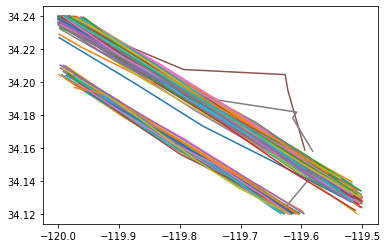

In [32]:
lEFileNum = 2
errorVal = []
for lEFileNum in range(400):
    oneVessel = "../Data/M120_00_M190_50_34_12_34_24/MMSIGroup/"+str(lEFileNum)+".csv"
    oneVesselLastData,_ = aISDM.load_data_from_csv(oneVessel)
    oneVesselLastDataLon = oneVesselLastData["LON"]
    oneVesselLastDataLat = oneVesselLastData["LAT"]
    plt.plot(oneVesselLastDataLon,oneVesselLastDataLat)
    print(oneVesselLastData)

    vesselPrevState = get_vessel_init_status(oneVesselLastDataLon.iloc[0],oneVesselLastDataLat.iloc[0])
    vesselCurrState = get_vessel_init_status(oneVesselLastDataLon.iloc[1],oneVesselLastDataLat.iloc[1])
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    onePredict = []
    for i in range((oneVesselLastData.shape[0]-2)):
        vesselProbState = generate_path(vesselState)
        onePredict.append(vesselProbState.copy())
        vesselPrevState = vesselCurrState.copy()
        vesselCurrState = vesselProbState.copy()
        vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)


    #lets compute the error
    predictedLastLoc = np.argmax(onePredict[-1])
    actualLastLoc = get_index_from_lon_lat(oneVesselLastDataLon.iloc[-1],oneVesselLastDataLat.iloc[-1])
    print(predictedLastLoc)
    print(actualLastLoc)
    predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc][0] \
                                                    ,boundaryArray[predictedLastLoc][1]\
                                                    ,boundaryArray[predictedLastLoc][2]\
                                                    ,boundaryArray[predictedLastLoc][3]\
                                                    )

    actualLastLocCord = hMUtil.compute_mid_point(boundaryArray[actualLastLoc][0] \
                                                    ,boundaryArray[actualLastLoc][1]\
                                                    ,boundaryArray[actualLastLoc][2]\
                                                    ,boundaryArray[actualLastLoc][3]\
                                                    )

    errorPos = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
    print(errorPos)
    errorVal.append(errorPos)

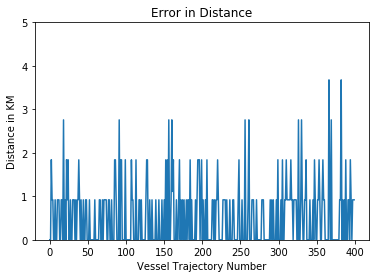

In [37]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim(0,5)
ax.set_title("Error in Distance")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal)
fig.savefig('SecondOrderError.png')

In [35]:
errorValNP = np.array(errorVal)
print(np.mean(errorValNP))

0.5383388078834508


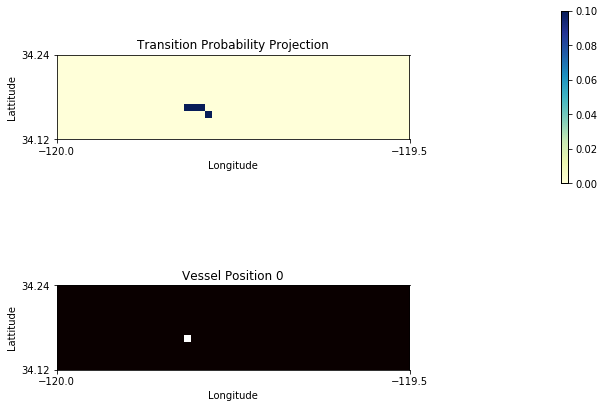

In [31]:
vesselPrevState = get_vessel_init_status(oneVesselLastDataLon.iloc[0],oneVesselLastDataLat.iloc[0])
vesselCurrState = get_vessel_init_status(oneVesselLastDataLon.iloc[1],oneVesselLastDataLat.iloc[1])
vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataLon.iloc[i+2],oneVesselLastDataLat.iloc[i+2])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    
    vesselProbState = onePredict[i].copy()
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=(oneVesselLastData.shape[0]-2), interval=1000)
HTML(anim.to_html5_video())
fileToStore = 'TPSeqOneSecOrder%d.mp4'%(lEFileNum)
anim.save(fileToStore, writer=writer)